In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
from sympy import Function, Derivative, Eq, symbols, factor, Symbol
from sympkf import SymbolicPKF, FDModelBuilder, clean_latex_name

from sympkf import t as time_coordinate

In [50]:
class PDESystem(object):
    """ Symbolic system of partial differential equations
    """

    _time_symbol = time_coordinate

    def __init__(self, equations, name=''):

        if not isinstance(equations, list):
            equations = [equations]

        self.equations = equations

        self.name = name

        # Set endogenous/exogenous fields
        self.functions = self._get_functions()
        self.prognostic_functions = self._get_prognostic_functions()
        self.constant_functions = self._get_constant_functions()
        self.exogenous_functions = self._get_exogenous_functions()

        # Set spatio/temporal coordinates
        self.coordinates = self._get_coordinates()
        self.spatial_coordinates = self._get_spatial_coordinates()
        self.time_coordinate = self.coordinates[0]

        # Set trainable scalar
        self.trainable_scalars = self._get_trainable_scalars()

        # Set constants
        self.constants = self._get_constants()

        # Set derivatives which appears in the system of pde
        self.spatial_derivatives = self._get_spatial_derivatives()


        self.derivative_max_order = max([0]+[derivative.derivative_count for derivative in self.spatial_derivatives])

    def __iter__(self):
        """ Build an iterator on the system equations """

        def iterator():
            for equation in self.equations:
                yield equation

        return iterator()

    def __getitem__(self, item):
        """ Get k'th equation of the system """
        return self.equations[item]

    def __repr__(self):
        """ Sumup of the PDESystem """
        """
        todo : add trainable_scalar
        """
        name = f"'{self.name}'" if self.name != '' else ''
        prognostic_functions = ", ".join([str(function)
                                          for function in self.prognostic_functions])
        exogenous_functions = ", ".join([str(function)
                                         for function in self.exogenous_functions])
        constant_functions = ", ".join([str(function)
                                        for function in self.constant_functions])
        constants = ", ".join([str(clean_latex_name(constant)) for constant in self.constants])
        trainable_scalars = ",".join([str(clean_latex_name(constant)) for constant in self.trainable_scalars])

        string = f'''PDE System {name}:
        prognostic functions : {prognostic_functions}
        constant functions   : {constant_functions}
        exogeneous functions : {exogenous_functions}
        constants            : {constants}
        '''
        if self.trainable_scalars != set():
            string += f'''
        trainable scalars    : {trainable_scalars}
            '''

        return string

    def _get_functions(self):
        """ Extract all functions present in the system of pde """

        functions = set()

        for equation in self.equations:
            functions.update(equation.atoms(Function))

        return functions

    def _get_prognostic_functions(self):
        """ Extract prognostic functions from the system of pde """

        prognostic_functions = []

        for equation in self.equations:
            derivatives = equation.atoms(Derivative)
            for derivative in derivatives:
                coordinates = derivative.args[1].atoms(Symbol)
                if self._time_symbol in coordinates:
                    prognostic_functions.append(derivative.args[0])

        return prognostic_functions

    def _get_constant_functions(self):
        # Selects constant variables (which is a function of time free coordinate)

        constant_functions = set()

        for variable in self.functions.difference(self.prognostic_functions):
            coordinates = variable.args[0].atoms(Symbol)
            if self._time_symbol not in coordinates:
                constant_functions.update({variable})

        return constant_functions

    def _get_exogenous_functions(self):
        """ Extract diagnostic / exogenous functions

        .. Warning:
            there is not difference here between diagnostic and exogenous functions.
        """

        # Extract diagnostic/exogenous functions from all functions
        exogenous_functions = self.functions.difference(self.prognostic_functions)
        exogenous_functions.difference_update(self.constant_functions)

        return exogenous_functions

    def _get_coordinates(self):
        """ Extract spatial coordinates from arguments of prognostic functions """
        coordinates = ()
        for function in self.functions:
            args = function.args
            if len(args) > len(coordinates):
                coordinates = args
        return coordinates

    def _get_spatial_coordinates(self):
        assert self.coordinates[0] == self._time_symbol
        return self.coordinates[1:]

    def _get_constants(self):
        ''' List all Constant from a system of PDE '''

        constants = set()  # use set to only select one single sample of a given constant (no duplication)
        for equation in self.equations:
            rhs = equation.args[1]
            trainable = rhs.atoms(TrainableScalar)
            # Only retain constants that are not coordinate nor trainable
            constants.update(rhs.atoms(Symbol).difference(self.coordinates).difference(trainable))

        return constants

    def _get_trainable_scalars(self):
        ''' List all Constant from a system of PDE '''

        trainable_scalars = set()  # use set to only select one single sample of a given constant (no duplication)
        for equation in self.equations:
            rhs = equation.args[1]
            trainable_scalars.update(rhs.atoms(TrainableScalar))

        return trainable_scalars

    def _get_spatial_derivatives(self):
        ''' List all Derivative from a system of PDE '''

        # -1- Check all derivatives
        spatial_derivatives = set()  # use set to only select one single sample of a given derivative (no duplication)
        # loop over equations
        for equation in self.equations:
            # extract constant from rhs of equations
            rhs = equation.args[1]
            spatial_derivatives.update(rhs.atoms(Derivative))

        return spatial_derivatives

    @property
    def finite_difference(self):
        """ Compute the finite difference discretization of a system of pde """
        from .finite_difference import finite_difference, Eq

        orders = list(range(1, self.derivative_max_order + 1))
        orders.reverse()

        finite_difference_system = []

        for equation in self.equations:
            # -1- extract lhs/rhs
            lhs, rhs = equation.args
            # -2- finite difference of rhs
            rhs = finite_difference(rhs)
            # -3- update the system
            finite_difference_system.append(Eq(lhs, rhs))

        return finite_difference_system

# Domaine

In [51]:
import sympy
sympy.init_printing() 

In [52]:
t, x, y = symbols('t x y')
lbda = symbols('lambda')

u = Function('u')(t, x)
psi = Function('psi')(t, x)
q = Function('q')(t, x)

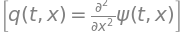

In [53]:
# set the equations
Equations = [Eq(q, Derivative(psi, x, 2))]
Equations

In [54]:
test = PDESystem(Equations)

In [57]:
test

PDE System :
        prognostic functions : 
        constant functions   : 
        exogeneous functions : q(t, x), psi(t, x)
        constants            : 
        